In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('chunk_70.csv')
df.head(5)
df.info()
df.describe()
df.shape
df.columns
print(df.isnull().sum())
print(df.describe(include=['object']))
print(df['review_stars'].value_counts())
print(df['text'].head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49691 entries, 0 to 49690
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   49691 non-null  object 
 1   name          49691 non-null  object 
 2   address       49591 non-null  object 
 3   city          49691 non-null  object 
 4   state         49691 non-null  object 
 5   postal_code   49691 non-null  object 
 6   latitude      49691 non-null  float64
 7   longitude     49691 non-null  float64
 8   stars         49691 non-null  float64
 9   attributes    49520 non-null  object 
 10  categories    49691 non-null  object 
 11  user_id       49691 non-null  object 
 12  review_stars  49691 non-null  int64  
 13  text          49691 non-null  object 
 14  date          49691 non-null  object 
dtypes: float64(3), int64(1), object(11)
memory usage: 5.7+ MB
business_id       0
name              0
address         100
city              0
state            

In [4]:
# Drop unnecessary columns
unnecessary_columns = ['name','business_id','address','city','state','postal_code','address', 'latitude', 'longitude', 'stars', 'attributes', 'categories', 'user_id', 'date']
df.drop(columns=unnecessary_columns, inplace=True, errors='ignore')
print(df.isnull().sum())
# Handle missing values
#df['text'] = df['text'].fillna('')  # Fill missing reviews with empty string
#df['review_stars'] = df['review_stars'].fillna(df['review_stars'].mode()[0])  # Fill missing review stars with the mode


review_stars    0
text            0
dtype: int64


In [5]:
df.head(5)

,review_stars,text
0,1,Stupid expensive. Cute inside and outside. Ver...
1,2,Outrageous service for a wine bar! Twenty dol...
2,5,This corner shop is awesome - the banh mi's ar...
3,5,"Looking for a classic Ramen house feel, but we..."
4,5,First Time Here !!!\n\nThe wait wasn't long an...


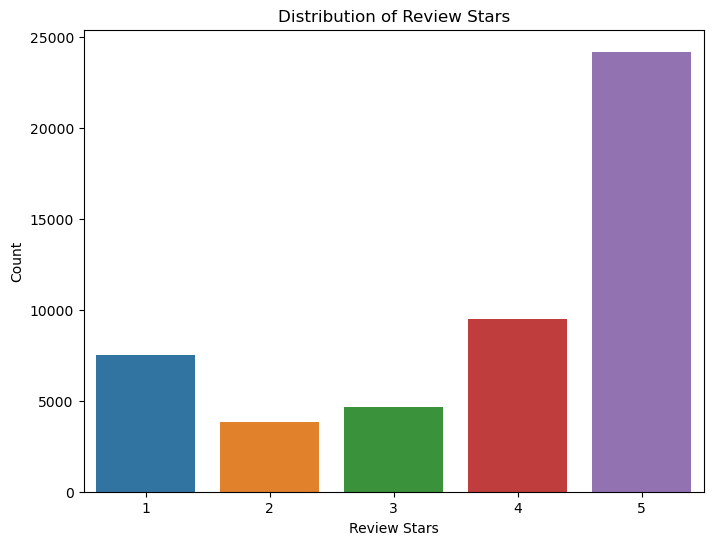

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# 1. Distribution of Review Stars
plt.figure(figsize=(8, 6))
sns.countplot(x='review_stars', data=df)
plt.title('Distribution of Review Stars')
plt.xlabel('Review Stars')
plt.ylabel('Count')
plt.show()



In [9]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load dataset

# Function to clean text
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

df['cleaned_review'] = df['text'].apply(preprocess_text)

# Convert Rating to Sentiment
df['sentiment'] = df['review_stars'].apply(lambda x: 'positive' if x >= 4 else 'negative')

# Print sample data
print(df[['cleaned_review', 'sentiment']].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\priya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                      cleaned_review sentiment
0  stupid expensive cute inside outside small ser...  negative
1  outrageous service wine bar twenty dollars gla...  negative
2  corner shop awesome banh mis delicious lunch h...  positive
3  looking classic ramen house feel well weather ...  positive
4  first time wait wasnt long server nice got reg...  positive


sentiment
positive    33685
negative    16006
Name: count, dtype: int64


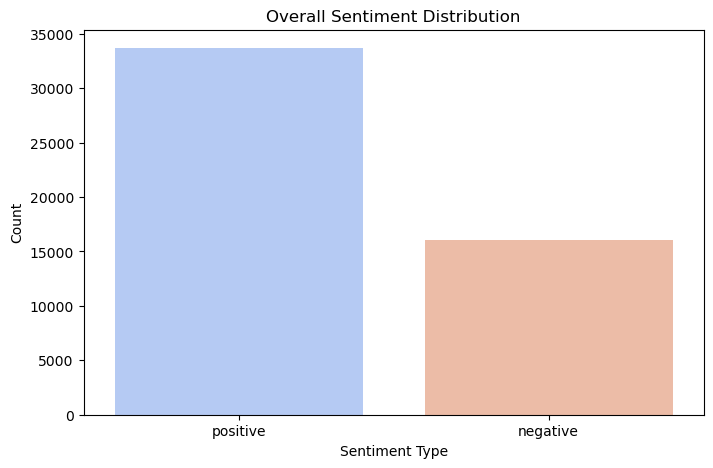

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each sentiment
sentiment_counts = df["sentiment"].value_counts()

# Display sentiment distribution
print(sentiment_counts)
# Plot the sentiment distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")
plt.xlabel("Sentiment Type")
plt.ylabel("Count")
plt.title("Overall Sentiment Distribution")
plt.show()


In [13]:
text_1 = " ".join(df.loc[df['sentiment'] == 'positive', 'cleaned_review'].dropna())
text_0 = " ".join(df.loc[df['sentiment'] == 'negative', 'cleaned_review'].dropna())


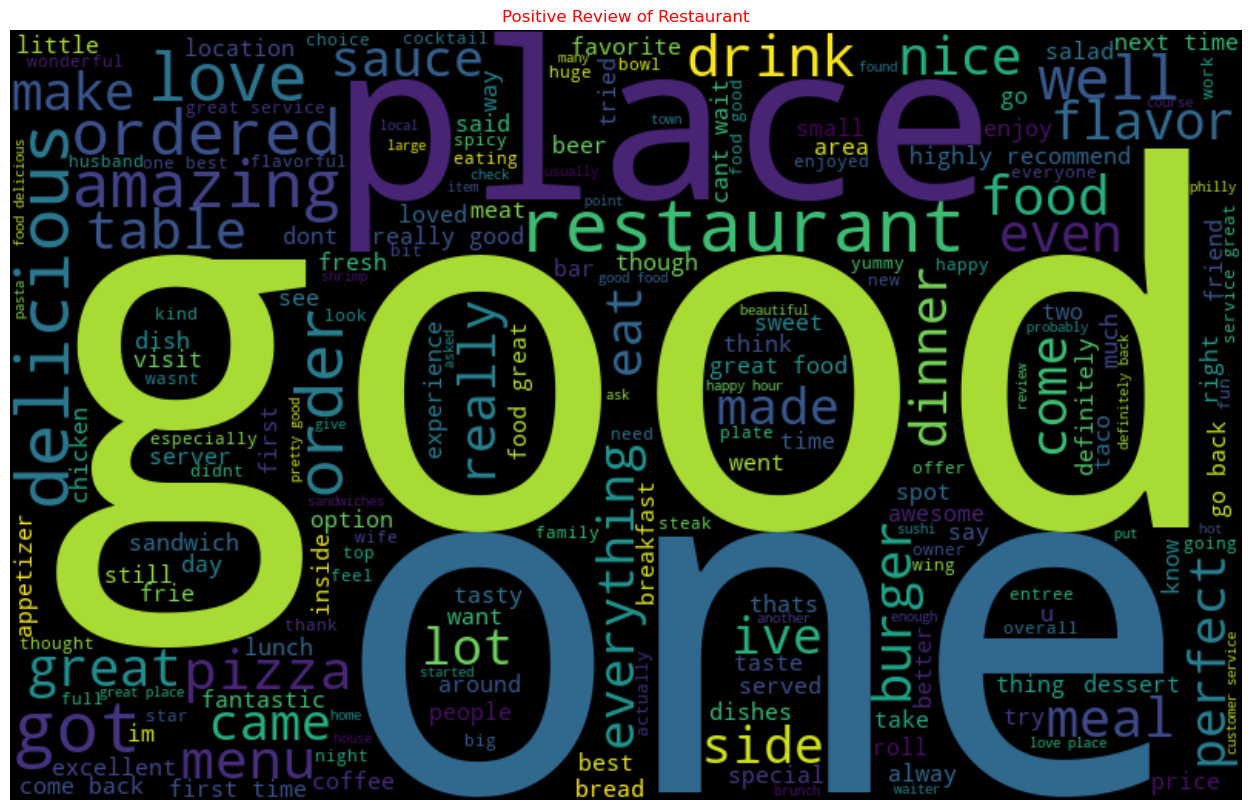

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
words_1=WordCloud(width=800,height=500,background_color="black").generate(text_1)
plt.figure(figsize=(20, 10))
plt.imshow(words_1, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Review of Restaurant",color="Red")
plt.show()

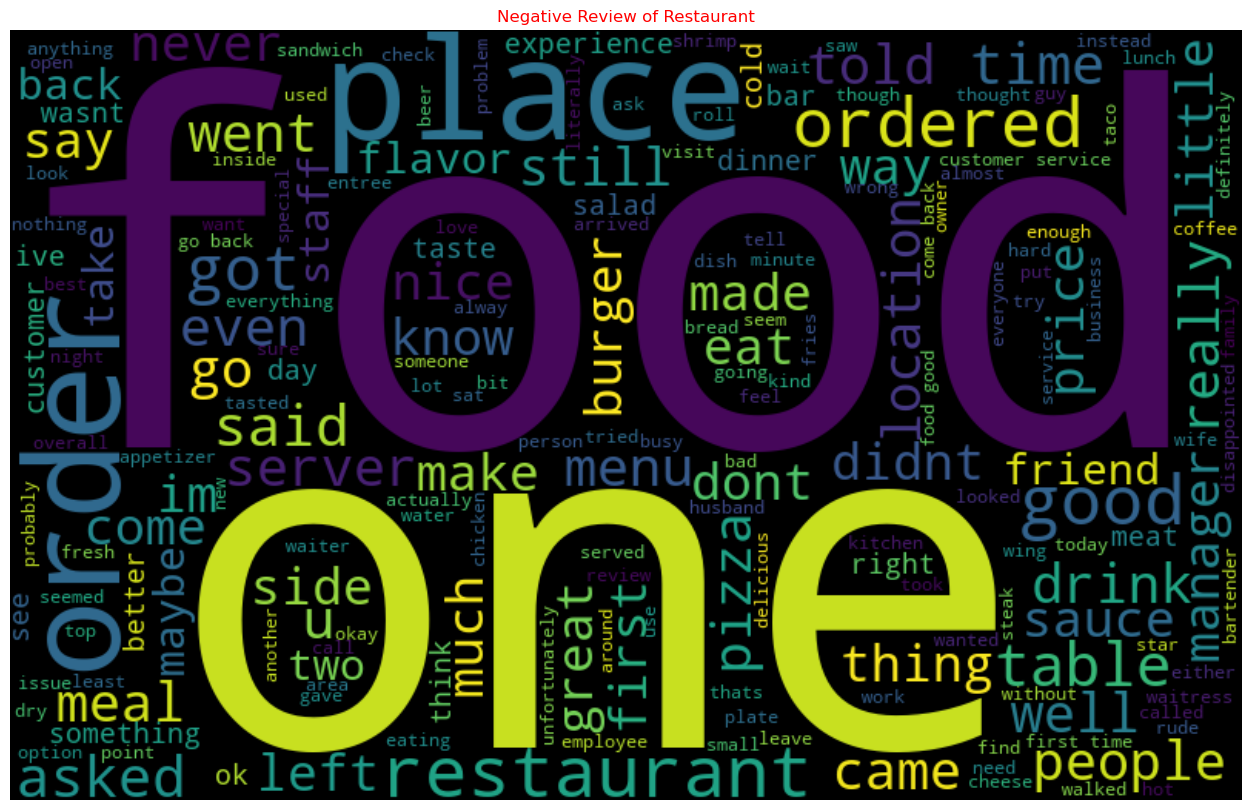

In [15]:
words_0=WordCloud(width=800,height=500,background_color="black").generate(text_0)
#words_1=WordCloud(width=800,height=500,background_color="black").generate(text_1)
plt.figure(figsize=(20, 10))
plt.imshow(words_0, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Review of Restaurant",color="Red")
plt.show()

prepare data for training

In [11]:
# Define keywords for aspect classification
food_keywords = [
    # General Food Terms
    "food", "dish", "meal", "cuisine", "delicacy", "recipe", "flavor", "taste", "savory", "delicious", "spicy",
    "yummy", "tasty", "scrumptious", "delectable", "mouthwatering", "appetizing", "finger-licking",

    # Fast Food
    "pizza", "burger", "fries", "nuggets", "hotdog", "sandwich", "wrap", "shawarma", "donut", "cheeseburger",
    "sub", "burrito", "nachos", "taco", "quesadilla",

    # Beverages
    "coffee", "tea", "juice", "smoothie", "soda", "cocktail", "mocktail", "milkshake", "latte", "espresso",
    "mocha", "americano", "lemonade", "beer", "wine", "whiskey", "vodka",

    # Sweet & Desserts
    "cake", "ice cream", "chocolate", "brownie", "cupcake", "pastry", "pudding", "cheesecake", "tart",
    "muffin", "cookies", "sorbet", "fudge", "truffle", "candy", "caramel", "honey",

    # Fruits & Vegetables
    "apple", "banana", "grapes", "orange", "strawberry", "mango", "pineapple", "watermelon", "blueberry",
    "peach", "avocado", "cherry", "papaya", "kiwi", "lettuce", "broccoli", "carrot", "spinach", "cucumber",
    "tomato", "onion", "pepper", "garlic", "potato", "cauliflower", "beetroot",

    # International Cuisines
    "pasta", "lasagna", "sushi", "ramen", "noodles", "dim sum", "curry", "tandoori", "biryani", "paella",
    "gyros", "falafel", "hummus", "kimchi", "dumplings", "bruschetta", "risotto", "tempura", "teriyaki",

    # Meat & Seafood
    "chicken", "beef", "steak", "pork", "bacon", "ribs", "ham", "salmon", "shrimp", "lobster", "crab",
    "tuna", "sardine", "mackerel", "oysters", "squid", "clams",

    # Dairy & Cheese
    "cheese", "butter", "cream", "yogurt", "milk", "parmesan", "mozzarella", "cheddar", "brie", "gouda",
    "ricotta", "feta", "blue cheese",

    # Spices & Condiments
    "salt", "pepper", "sugar", "vinegar", "sauce", "ketchup", "mustard", "mayonnaise", "curry", "herbs",
    "basil", "oregano", "rosemary", "thyme", "cinnamon", "paprika", "turmeric", "cumin", "ginger", "nutmeg",

    # Miscellaneous
    "organic", "fresh", "grilled", "fried", "baked", "roasted", "steamed", "boiled", "homemade", "gourmet"
]

service_keywords = [
    # General Service Terms
    "service", "customer service", "hospitality", "staff", "employee", "team", "management", "support",
    "attentive", "professional", "helpful", "courteous", "polite", "welcoming", "friendly", "approachable",

    # Negative Service Experiences
    "slow", "rude", "unprofessional", "disrespectful", "impolite", "ignorant", "neglect", "lazy", "arrogant",
    "unhelpful", "argumentative", "irresponsible", "unresponsive", "careless", "incompetent",

    # Speed & Efficiency
    "fast", "quick", "efficient", "prompt", "timely", "delayed", "waiting", "long wait", "slow service",
    "speedy", "instant", "hurry", "rush", "on time", "late", "delay",

    # Waiters & Staff Roles
    "waiter", "waitress", "server", "bartender", "cashier", "host", "receptionist", "chef", "cook",
    "barista", "manager", "owner", "delivery guy", "driver", "security",

    # Orders & Handling Complaints
    "order", "wrong order", "forgot order", "late order", "confused", "miscommunication", "messed up",
    "complaint", "resolve", "issue", "problem", "refund", "replacement", "customer care", "phone support",

    # Tipping & Additional Charges
    "tip", "gratuity", "overcharge", "hidden fees", "extra charge", "billing issue", "expensive service"
]

ambience_keywords = [
    # General Ambience & Experience
    "ambience", "atmosphere", "environment", "vibe", "aesthetic", "mood", "decor", "interior",
    "design", "style", "theme", "art", "layout", "architecture", "luxurious", "modern", "traditional",

    # Lighting & Visual Effects
    "lighting", "brightness", "dim lights", "neon", "fairy lights", "warm lighting", "candlelight",
    "dark", "glow", "flashy", "spotlight", "chandeliers", "cozy lighting",

    # Music & Sound
    "music", "playlist", "live music", "band", "singer", "DJ", "soft music", "loud music", "noise",
    "quiet", "echo", "acoustics", "background music", "annoying sound", "peaceful",

    # Cleanliness & Hygiene
    "clean", "dirty", "hygiene", "sanitary", "smelly", "odors", "fresh", "dusty", "stains", "tidy",
    "neat", "garbage", "trash", "restroom", "bathroom", "toilet", "sink", "soap", "towels",

    # Space & Seating
    "spacious", "crowded", "congested", "cozy", "comfortable", "seating", "chairs", "sofa", "table",
    "booth", "bar area", "rooftop", "outdoor seating", "patio", "balcony", "terrace", "private dining",

    # Temperature & Air Quality
    "air conditioning", "AC", "heater", "warm", "cold", "ventilation", "fresh air", "smoky", "humid", "breeze",

    # Special Elements
    "fireplace", "fountain", "poolside", "garden", "greenery", "plants", "flowers", "artwork", "murals",
    "candles", "scent", "incense"
]

# Function to assign aspect
def assign_aspects(review):
    aspects = []
    if any(word in review for word in food_keywords):
        aspects.append("Food")
    if any(word in review for word in service_keywords):
        aspects.append("Service")
    if any(word in review for word in ambience_keywords):
        aspects.append("Ambience")

    return aspects if aspects else ["General"]

# Apply the function to assign multiple aspects
df['aspect'] = df['cleaned_review'].apply(assign_aspects)

# Print aspect-based classification
print(df[['cleaned_review', 'aspect']].head())



                                      cleaned_review  \
0  stupid expensive cute inside outside small ser...   
1  outrageous service wine bar twenty dollars gla...   
2  corner shop awesome banh mis delicious lunch h...   
3  looking classic ramen house feel well weather ...   
4  first time wait wasnt long server nice got reg...   

                      aspect  
0            [Food, Service]  
1  [Food, Service, Ambience]  
2            [Food, Service]  
3            [Food, Service]  
4            [Food, Service]  


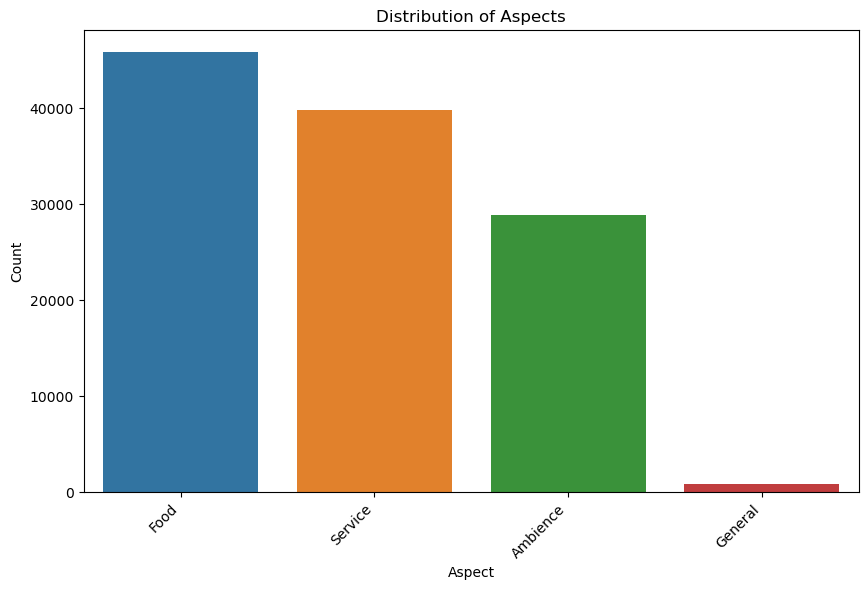

In [12]:
# 5. Aspect Distribution
aspect_counts = Counter(df['aspect'].sum())  # Assuming 'aspect' is a list of aspects
aspect_df = pd.DataFrame.from_dict(aspect_counts, orient='index', columns=['Count'])
aspect_df.sort_values(by='Count', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=aspect_df.index, y=aspect_df['Count'])
plt.title('Distribution of Aspects')
plt.xlabel('Aspect')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

In [ ]:
unique_aspect_lists = df['aspect'].apply(tuple).unique().tolist()

print(unique_aspect_lists)


In [ ]:
# import re
# import nltk
# from nltk.corpus import stopwords

# nltk.download('stopwords')
# stop_words = set(stopwords.words('english'))

# def preprocess_input_text(text):
#     text = text.lower()  # Lowercase
#     text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
#     text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters and punctuation
#     text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stop words
#     return text

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Step 1: Label Encoding (Before Splitting)
label_encoder = LabelEncoder()
df['encoded_sentiment'] = label_encoder.fit_transform(df['sentiment'])  # Encode the full column first

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_review'], df['encoded_sentiment'], test_size=0.2, random_state=42)

# Step 3: Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Check unique encoded labels
print("Encoded Classes:", label_encoder.classes_)


Encoded Classes: ['negative' 'positive']


In [18]:
import joblib

# Save the trained TF-IDF vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

print("TF-IDF vectorizer saved successfully!")


TF-IDF vectorizer saved successfully!


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

In [20]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "Naive Bayes": MultinomialNB(),
    "KNN": KNeighborsClassifier(),
    "XGBoost": xgb.XGBClassifier()
}

# Train and" Evaluate Each Model
results = {}
for model_name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

# Find the best model based on accuracy
best_model = max(results, key=results.get)
print(f"\nBest Model: {best_model} with Accuracy: {results[best_model]:.4f}")


Model: Logistic Regression
Accuracy: 0.9190
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      3252
           1       0.93      0.96      0.94      6687

    accuracy                           0.92      9939
   macro avg       0.91      0.90      0.91      9939
weighted avg       0.92      0.92      0.92      9939

Model: Random Forest
Accuracy: 0.8903
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      3252
           1       0.88      0.97      0.92      6687

    accuracy                           0.89      9939
   macro avg       0.90      0.85      0.87      9939
weighted avg       0.89      0.89      0.89      9939

Model: SVM
Accuracy: 0.9242
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      3252
           1       0.93      0.96      0.94      6687

    accuracy                           0.92      9939
   macro avg      

In [31]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

# Create an empty list to store results
report_data = []

# Iterate over models and generate classification reports
for model_name, model in models.items():
    y_pred = model.predict(X_test_tfidf)
    report = classification_report(y_test, y_pred, output_dict=True)  # Convert report to dictionary
    accuracy = accuracy_score(y_test, y_pred)  # Compute accuracy

    for label, metrics in report.items():
        if label.isdigit():  # Only include class labels, skip 'accuracy'
            report_data.append({
                "Model": model_name,
                "Class": label,
                "Precision": round(metrics["precision"], 4),
                "Recall": round(metrics["recall"], 4),
                "F1-Score": round(metrics["f1-score"], 4),
                "Support": int(metrics["support"]),
                "Accuracy": round(accuracy, 4)  # Add accuracy for each model
            })

# Convert to DataFrame
df_report = pd.DataFrame(report_data)

# Display formatted table
print(df_report)


                  Model Class  Precision  Recall  F1-Score  Support  Accuracy
0   Logistic Regression     0     0.9034  0.8426    0.8719     3252    0.9190
1   Logistic Regression     1     0.9259  0.9562    0.9408     6687    0.9190
2         Random Forest     0     0.9139  0.7340    0.8141     3252    0.8903
3         Random Forest     1     0.8819  0.9664    0.9222     6687    0.8903
4                   SVM     0     0.9120  0.8506    0.8802     3252    0.9242
5                   SVM     1     0.9296  0.9601    0.9446     6687    0.9242
6           Naive Bayes     0     0.9176  0.7125    0.8021     3252    0.8850
7           Naive Bayes     1     0.8739  0.9689    0.9189     6687    0.8850
8                   KNN     0     0.8519  0.4422    0.5822     3252    0.7923
9                   KNN     1     0.7801  0.9626    0.8618     6687    0.7923
10              XGBoost     0     0.8774  0.8029    0.8385     3252    0.8988
11              XGBoost     1     0.9079  0.9454    0.9263     6

In [26]:
results

{'Logistic Regression': 0.9190059362108864,
 'Random Forest': 0.8903310192172251,
 'SVM': 0.9242378508904316,
 'Naive Bayes': 0.8849984907938424,
 'KNN': 0.7923332327195894,
 'XGBoost': 0.8987825736995674}

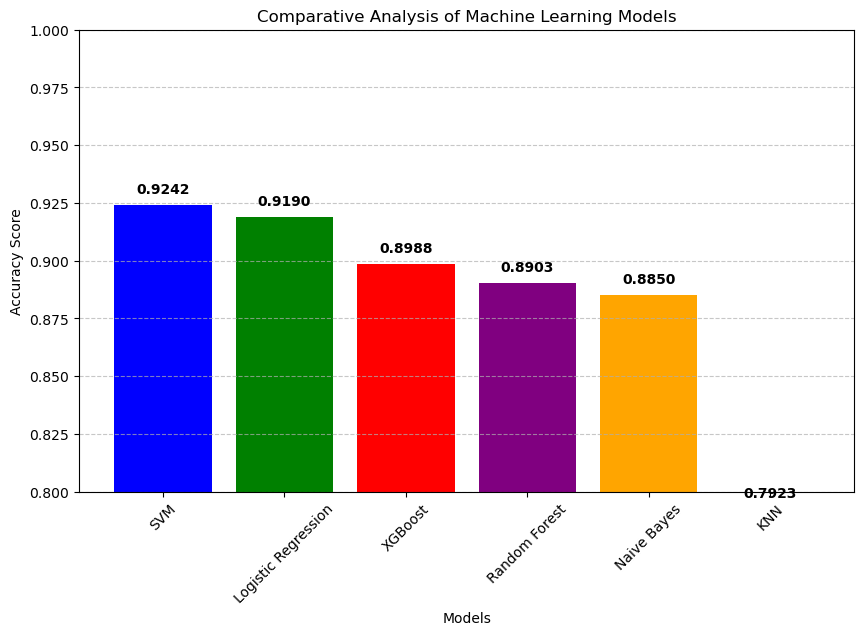

In [27]:
sorted_results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_results.keys(), sorted_results.values(), color=['blue', 'green', 'red', 'purple', 'orange', 'cyan'])

# Add labels and title
plt.xlabel("Models")
plt.ylabel("Accuracy Score")
plt.title("Comparative Analysis of Machine Learning Models")
plt.ylim(0.8, 1.0)  # Adjust y-axis for clarity
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display accuracy values on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.4f}", ha='center', fontsize=10, fontweight='bold')

# Show the plot
plt.show()

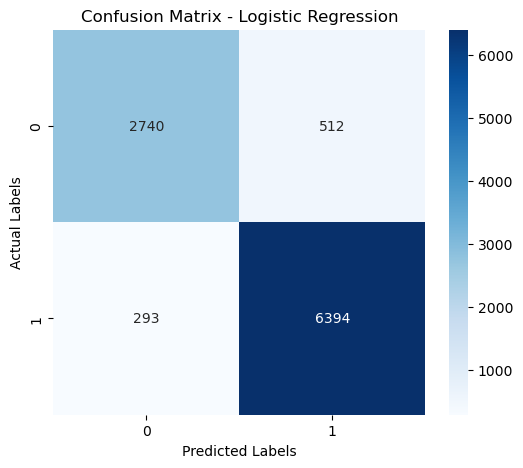

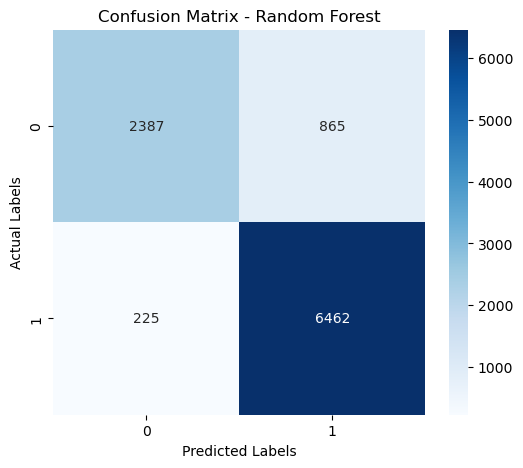

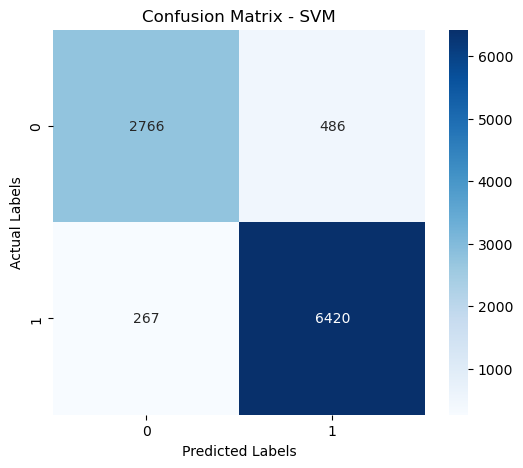

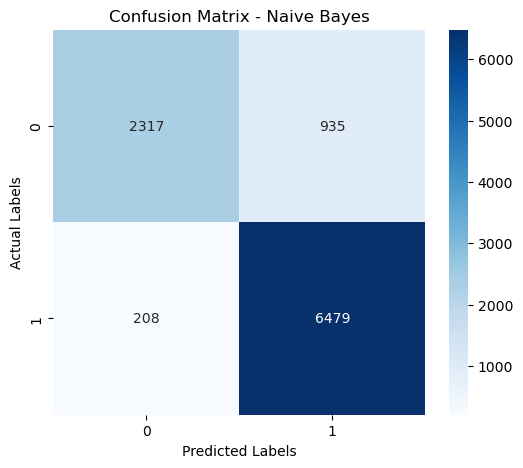

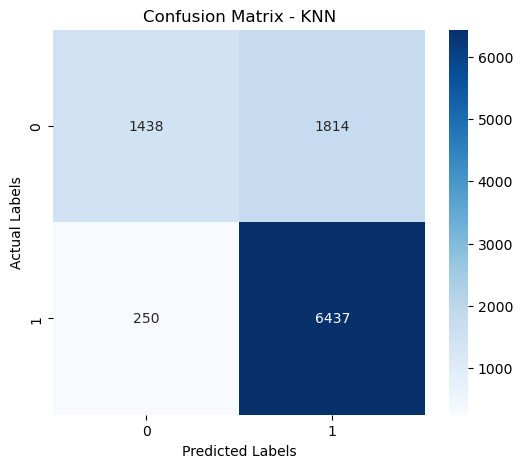

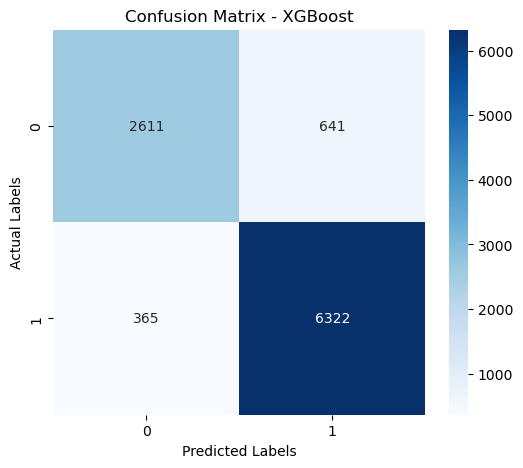

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Iterate over models and plot confusion matrix
for model_name, model in models.items():
    y_pred = model.predict(X_test_tfidf)
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot the heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted Labels")
    plt.ylabel("Actual Labels")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


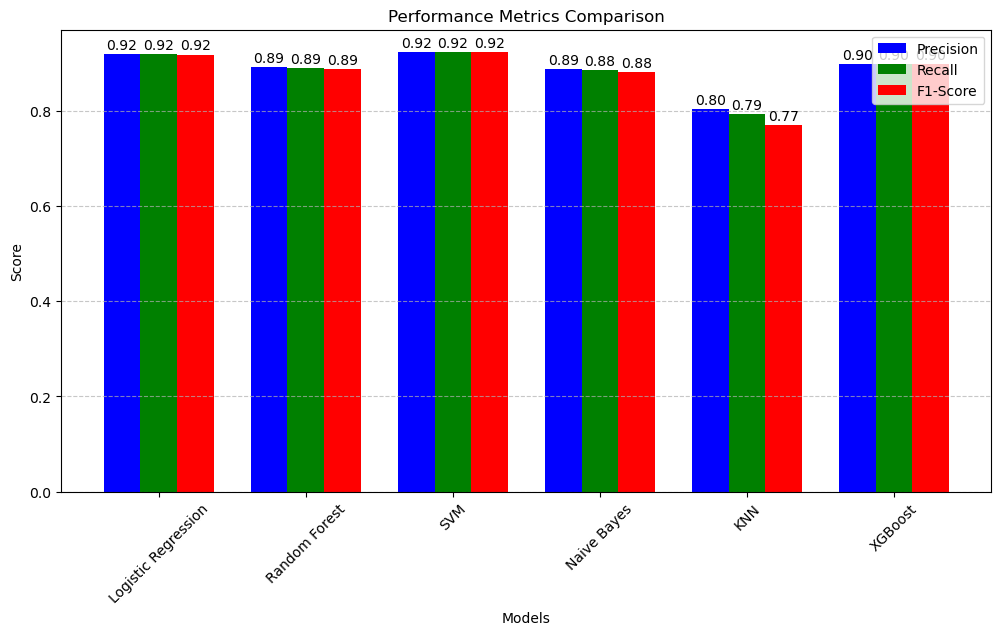

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Dictionary to store performance metrics
performance_metrics = {
    "Model": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": []
}

# Evaluate each model
for model_name, model in models.items():
    y_pred = model.predict(X_test_tfidf)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Store metrics
    performance_metrics["Model"].append(model_name)
    performance_metrics["Precision"].append(precision)
    performance_metrics["Recall"].append(recall)
    performance_metrics["F1-Score"].append(f1)

# Convert to numpy array for plotting
labels = performance_metrics["Model"]
precision_vals = performance_metrics["Precision"]
recall_vals = performance_metrics["Recall"]
f1_vals = performance_metrics["F1-Score"]

# Set position of bars on X axis
x = np.arange(len(labels))
width = 0.25  # Width of bars

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width, precision_vals, width, label="Precision", color="blue")
ax.bar(x, recall_vals, width, label="Recall", color="green")
ax.bar(x + width, f1_vals, width, label="F1-Score", color="red")

# Add labels and title
ax.set_xlabel("Models")
ax.set_ylabel("Score")
ax.set_title("Performance Metrics Comparison")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Display values on bars
for i in range(len(labels)):
    plt.text(i - width, precision_vals[i] + 0.01, f"{precision_vals[i]:.2f}", ha='center', fontsize=10)
    plt.text(i, recall_vals[i] + 0.01, f"{recall_vals[i]:.2f}", ha='center', fontsize=10)
    plt.text(i + width, f1_vals[i] + 0.01, f"{f1_vals[i]:.2f}", ha='center', fontsize=10)

# Show the plot
plt.show()


In [21]:
import joblib
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train SVM model
svm_model = SVC()
svm_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = svm_model.predict(X_test_tfidf)

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Save the trained model as 'svm_restaurant.pkl'
joblib.dump(svm_model, 'svm_model.pkl')
print("Model saved successfully!")


SVM Accuracy: 0.9242
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.85      0.88      3252
           1       0.93      0.96      0.94      6687

    accuracy                           0.92      9939
   macro avg       0.92      0.91      0.91      9939
weighted avg       0.92      0.92      0.92      9939

Model saved successfully!


In [22]:
import spacy

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Aspect-based keywords
food_keywords = [
    # General Food Terms
    "food", "dish", "meal", "cuisine", "delicacy", "recipe", "flavor", "taste", "savory", "delicious", "spicy",
    "yummy", "tasty", "scrumptious", "delectable", "mouthwatering", "appetizing", "finger-licking",

    # Fast Food
    "pizza", "burger", "fries", "nuggets", "hotdog", "sandwich", "wrap", "shawarma", "donut", "cheeseburger",
    "sub", "burrito", "nachos", "taco", "quesadilla",

    # Beverages
    "coffee", "tea", "juice", "smoothie", "soda", "cocktail", "mocktail", "milkshake", "latte", "espresso",
    "mocha", "americano", "lemonade", "beer", "wine", "whiskey", "vodka",

    # Sweet & Desserts
    "cake", "ice cream", "chocolate", "brownie", "cupcake", "pastry", "pudding", "cheesecake", "tart",
    "muffin", "cookies", "sorbet", "fudge", "truffle", "candy", "caramel", "honey",

    # Fruits & Vegetables
    "apple", "banana", "grapes", "orange", "strawberry", "mango", "pineapple", "watermelon", "blueberry",
    "peach", "avocado", "cherry", "papaya", "kiwi", "lettuce", "broccoli", "carrot", "spinach", "cucumber",
    "tomato", "onion", "pepper", "garlic", "potato", "cauliflower", "beetroot",

    # International Cuisines
    "pasta", "lasagna", "sushi", "ramen", "noodles", "dim sum", "curry", "tandoori", "biryani", "paella",
    "gyros", "falafel", "hummus", "kimchi", "dumplings", "bruschetta", "risotto", "tempura", "teriyaki",

    # Meat & Seafood
    "chicken", "beef", "steak", "pork", "bacon", "ribs", "ham", "salmon", "shrimp", "lobster", "crab",
    "tuna", "sardine", "mackerel", "oysters", "squid", "clams",

    # Dairy & Cheese
    "cheese", "butter", "cream", "yogurt", "milk", "parmesan", "mozzarella", "cheddar", "brie", "gouda",
    "ricotta", "feta", "blue cheese",

    # Spices & Condiments
    "salt", "pepper", "sugar", "vinegar", "sauce", "ketchup", "mustard", "mayonnaise", "curry", "herbs",
    "basil", "oregano", "rosemary", "thyme", "cinnamon", "paprika", "turmeric", "cumin", "ginger", "nutmeg",

    # Miscellaneous
    "organic", "fresh", "grilled", "fried", "baked", "roasted", "steamed", "boiled", "homemade", "gourmet"
]

service_keywords = [
    # General Service Terms
    "service", "customer service", "hospitality", "staff", "employee", "team", "management", "support",
    "attentive", "professional", "helpful", "courteous", "polite", "welcoming", "friendly", "approachable",

    # Negative Service Experiences
    "slow", "rude", "unprofessional", "disrespectful", "impolite", "ignorant", "neglect", "lazy", "arrogant",
    "unhelpful", "argumentative", "irresponsible", "unresponsive", "careless", "incompetent",

    # Speed & Efficiency
    "fast", "quick", "efficient", "prompt", "timely", "delayed", "waiting", "long wait", "slow service",
    "speedy", "instant", "hurry", "rush", "on time", "late", "delay",

    # Waiters & Staff Roles
    "waiter", "waitress", "server", "bartender", "cashier", "host", "receptionist", "chef", "cook",
    "barista", "manager", "owner", "delivery guy", "driver", "security",

    # Orders & Handling Complaints
    "order", "wrong order", "forgot order", "late order", "confused", "miscommunication", "messed up",
    "complaint", "resolve", "issue", "problem", "refund", "replacement", "customer care", "phone support",

    # Tipping & Additional Charges
    "tip", "gratuity", "overcharge", "hidden fees", "extra charge", "billing issue", "expensive service"
]

ambience_keywords = [
    # General Ambience & Experience
    "ambience", "atmosphere", "environment", "vibe", "aesthetic", "mood", "decor", "interior",
    "design", "style", "theme", "art", "layout", "architecture", "luxurious", "modern", "traditional",

    # Lighting & Visual Effects
    "lighting", "brightness", "dim lights", "neon", "fairy lights", "warm lighting", "candlelight",
    "dark", "glow", "flashy", "spotlight", "chandeliers", "cozy lighting",

    # Music & Sound
    "music", "playlist", "live music", "band", "singer", "DJ", "soft music", "loud music", "noise",
    "quiet", "echo", "acoustics", "background music", "annoying sound", "peaceful",

    # Cleanliness & Hygiene
    "clean", "dirty", "hygiene", "sanitary", "smelly", "odors", "fresh", "dusty", "stains", "tidy",
    "neat", "garbage", "trash", "restroom", "bathroom", "toilet", "sink", "soap", "towels",

    # Space & Seating
    "spacious", "crowded", "congested", "cozy", "comfortable", "seating", "chairs", "sofa", "table",
    "booth", "bar area", "rooftop", "outdoor seating", "patio", "balcony", "terrace", "private dining",

    # Temperature & Air Quality
    "air conditioning", "AC", "heater", "warm", "cold", "ventilation", "fresh air", "smoky", "humid", "breeze",

    # Special Elements
    "fireplace", "fountain", "poolside", "garden", "greenery", "plants", "flowers", "artwork", "murals",
    "candles", "scent", "incense"
]

# Conjunctions commonly found in restaurant reviews
contrast_words = ["but", "however", "although", "yet", "while", "on the other hand", "though"]
coordinating_conjunctions = ["and", "or", "so", "moreover", "furthermore", "."]

In [24]:
def split_by_aspect(review):
    """Splits a review into aspect-based comments."""
    doc = nlp(review)
    segments = []
    start = 0

    # Identify points where splitting makes sense
    for token in doc:
        if token.text.lower() in contrast_words or token.text.lower() in coordinating_conjunctions:
            if start < token.idx:  # Avoid empty segments
                segments.append(review[start:token.idx].strip())  # Add sentence before conjunction
            start = token.idx + len(token.text)  # Move start point after conjunction

    if start < len(review):  # Add remaining part of the review
        segments.append(review[start:].strip())

    comments = []
    aspects = []

    # Assign aspects to each segment
    for segment in segments:
        if not segment:  # Skip empty segments
            continue

        segment_lower = segment.lower()
        segment_aspects = []

        if any(word in segment_lower for word in food_keywords):
            segment_aspects.append("Food")
        if any(word in segment_lower for word in service_keywords):
            segment_aspects.append("Service")
        if any(word in segment_lower for word in ambience_keywords):
            segment_aspects.append("Ambience")

        if not segment_aspects:
            segment_aspects.append("General")  # Default category if no aspect found

        comments.append(segment)
        aspects.append(segment_aspects)

    return comments, aspects


def predict_sentiments(comments, aspects):
    """Predict sentiment for a list of comments and return structured results."""
    processed_comments = [preprocess_text(comment) for comment in comments]  # Preprocess all comments
    transformed_comments = vectorizer.transform(processed_comments)  # Convert to TF-IDF
    predictions = model.predict(transformed_comments)  # Predict sentiment

    results = []
    for i in range(len(comments)):
        sentiment_label = "positive" if predictions[i] == 1 else "negative"
        results.append({
            "Comment": comments[i],
            "Aspects": aspects[i],
            "Sentiment": sentiment_label
        })

    return results


# Example Reviews
review_texts = [
    "The pizza was amazing, but the service was extremely slow. The waiter was rude, though the ambience was nice.",
    "The burger was cold and tasteless. However, the staff was very friendly, and the restaurant had a great atmosphere.",
    "The pasta was too salty, and the drinks were overpriced. But I really liked the music and the lighting was beautiful.",
    "The sushi was fresh and delicious, but the waiter took too long to bring our drinks. The place was beautifully decorated."
]

# Collect all comments and aspects
all_comments = []
all_aspects = []

for review in review_texts:
    comments, aspects = split_by_aspect(review)
    all_comments.extend(comments)  # Store all comments
    all_aspects.extend(aspects)  # Store all aspects

# Predict sentiment for all comments
predicted_results = predict_sentiments(all_comments, all_aspects)

# Print structured output
print("\n🔹 **Aspect-Based Sentiment Analysis Results:**")
for result in predicted_results:
    print(f"👉 **Comment:** '{result['Comment']}' → **Aspects:** {result['Aspects']} → **Sentiment:** {result['Sentiment']}")


🔹 **Aspect-Based Sentiment Analysis Results:**
👉 **Comment:** 'The pizza was amazing,' → **Aspects:** ['Food'] → **Sentiment:** positive
👉 **Comment:** 'the service was extremely slow' → **Aspects:** ['Service'] → **Sentiment:** negative
👉 **Comment:** 'The waiter was rude,' → **Aspects:** ['Service'] → **Sentiment:** negative
👉 **Comment:** 'the ambience was nice' → **Aspects:** ['Ambience'] → **Sentiment:** positive
👉 **Comment:** 'The burger was cold' → **Aspects:** ['Food', 'Ambience'] → **Sentiment:** negative
👉 **Comment:** 'tasteless' → **Aspects:** ['Food'] → **Sentiment:** negative
👉 **Comment:** ', the staff was very friendly,' → **Aspects:** ['Service'] → **Sentiment:** positive
👉 **Comment:** 'the restaurant had a great atmosphere' → **Aspects:** ['Ambience'] → **Sentiment:** positive
👉 **Comment:** 'The pasta was too salty,' → **Aspects:** ['Food'] → **Sentiment:** negative
👉 **Comment:** 'the drinks were overpriced' → **Aspects:** ['General'] → **Sentiment:** negative
👉 